# Statistics for the Overlap Between the Original STonKGs and the New ProtSTonKGs Files

This notebook visualizes the proportion of the new dataset subsets (specific to proteins) compared to the original datasets.

In [14]:
# Imports 
import getpass
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from matplotlib_venn import venn2
from transformers import BertTokenizer

from stonkgs.constants import (
    CELL_LINE_DIR,
    CELL_TYPE_DIR, 
    CORRECT_DIR, 
    DISEASE_DIR, 
    LOCATION_DIR, 
    ORGAN_DIR, 
    PRETRAINING_DIR,
    RELATION_TYPE_DIR, 
    SPECIES_DIR,
    VISUALIZATIONS_DIR,
)

Log when/how this notebook was created 

In [3]:
print(getpass.getuser())
print(sys.version)
print(time.asctime())

hbalabin
3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]
Thu Sep 16 09:42:27 2021


## 1. Load old and new datasets

In [8]:
directories = [
    CELL_LINE_DIR,
    CELL_TYPE_DIR,
    CORRECT_DIR,
    CORRECT_DIR,
    DISEASE_DIR,
    LOCATION_DIR,
    ORGAN_DIR,
    RELATION_TYPE_DIR,
    SPECIES_DIR,
    PRETRAINING_DIR,
]

names = [
    "cell_line", 
    "cell_type",
    "correct_incorrect_binary", 
    "correct_incorrect_multiclass", 
    "disease",
    "location",
    "organ", 
    "relation_type",
    "species",
    "pretraining",
]

old_file_names = [
    os.path.join(directory, name + "_no_duplicates.tsv") 
    for directory, name in zip(directories[:-1], names[:-1])
] + [os.path.join(directories[-1], names[-1] + "_triples.tsv")]

new_file_names = [
    os.path.join(directory, name + "_ppi_prot.tsv") 
    for directory, name in zip(directories, names)
]

old_files = [pd.read_csv(old_file_name, sep="\t", index_col=None) for old_file_name in old_file_names]
new_files = [pd.read_csv(new_file_name, sep="\t", index_col=None) for new_file_name in new_file_names]

## 2. Create Venn diagrams to compare the old and new files 
Create a set evidences for each dataset to construct the Venn diagrams. (Creating the Venn diagrams based on the unique set of (source, target, evidence) tuples exceeds a tolerable runtime:)

In [9]:
old_sets = [set(df["evidence"]) for df in old_files]
new_sets = [set(df["evidence"]) for df in new_files]

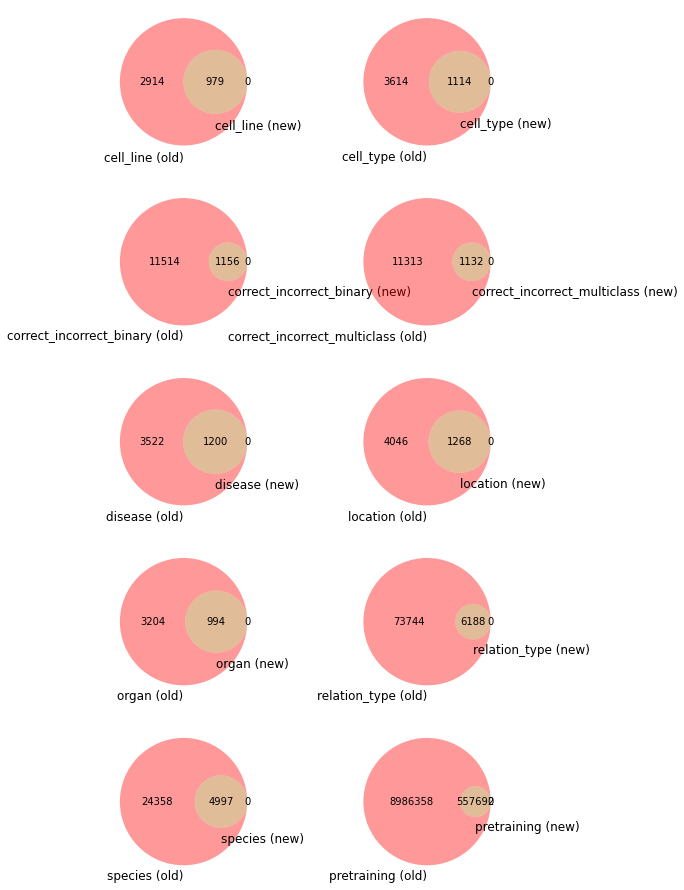

In [10]:
positions = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1), (3,0), (3,1), (4,0), (4,1)]

figure, axes = plt.subplots(5, 2, figsize=(8,16))

for old_set, new_set, name, position in zip(old_sets, new_sets, names, positions): 
    venn2([old_set, new_set], (name + " (old)", name + " (new)"), ax=axes[position[0]][position[1]])
    # TODO put in one figure and save 
    
plt.savefig(os.path.join(VISUALIZATIONS_DIR, "prot_stonkgs_overlaps.png"), dpi=300)
plt.show()

## 3. (TODO) Check average token length per modality in the new pretraining dataset
For the Knowledge Graph data, the "token length" (random walk length) is determined beforehand and can be thus adapted flexibly. 

In [11]:
pretraining_df = new_files[-1]
pretraining_df.head()

,source,relation,target,evidence,pmid,belief_score,source_id,target_id,source_description,target_description,source_prot,target_prot
0,p(HGNC:6016 ! IL5),decreases,p(HGNC:990 ! BCL2),"Furthermore, the expression of B-cell lymphoma...","other:""reach:Unknown""",{1: True},6016,990,This gene encodes a member of a subfamily of R...,The protein encoded by this gene is highly sim...,MDSGTRPVGSCCSSPAGLSREYKLVMLGAGGVGKSAMTMQFISHRF...,MPQTRSQAQATISFPKRKLSRALNKAKNSSDAKLEPTNVQTVTCSP...
1,p(HGNC:6016 ! IL5),increases,p(HGNC:990 ! BCL2),GM-CSF and IL-5 induce expression of Bcl-2 and...,"other:""reach:Unknown""",{1: True},6016,990,This gene encodes a member of a subfamily of R...,The protein encoded by this gene is highly sim...,MDSGTRPVGSCCSSPAGLSREYKLVMLGAGGVGKSAMTMQFISHRF...,MPQTRSQAQATISFPKRKLSRALNKAKNSSDAKLEPTNVQTVTCSP...
2,p(HGNC:6016 ! IL5),increases,p(HGNC:990 ! BCL2),IL-5 treatment can induce modest expression of...,"other:""reach:Unknown""",{1: True},6016,990,This gene encodes a member of a subfamily of R...,The protein encoded by this gene is highly sim...,MDSGTRPVGSCCSSPAGLSREYKLVMLGAGGVGKSAMTMQFISHRF...,MPQTRSQAQATISFPKRKLSRALNKAKNSSDAKLEPTNVQTVTCSP...
3,p(HGNC:6016 ! IL5),increases,p(HGNC:990 ! BCL2),"Interestingly, however, in eosinophils, Bcl-2 ...","other:""reach:Unknown""",{1: True},6016,990,This gene encodes a member of a subfamily of R...,The protein encoded by this gene is highly sim...,MDSGTRPVGSCCSSPAGLSREYKLVMLGAGGVGKSAMTMQFISHRF...,MPQTRSQAQATISFPKRKLSRALNKAKNSSDAKLEPTNVQTVTCSP...
4,p(HGNC:6016 ! IL5),increases,p(HGNC:990 ! BCL2),"Therefore, IL-5 dependent upregulation of the ...","other:""reach:Unknown""",{1: True},6016,990,This gene encodes a member of a subfamily of R...,The protein encoded by this gene is highly sim...,MDSGTRPVGSCCSSPAGLSREYKLVMLGAGGVGKSAMTMQFISHRF...,MPQTRSQAQATISFPKRKLSRALNKAKNSSDAKLEPTNVQTVTCSP...


In [13]:
protein_sequences = set(pretraining_df["source_prot"]).union(pretraining_df["target_prot"])
protein_descriptions = set(pretraining_df["source_description"]).union(pretraining_df["target_description"])
text_evidences = set(pretraining_df["evidence"])

Initialize a BioBERT Tokenizer to tokenize the text-based inputs

In [15]:
tokenizer = BertTokenizer.from_pretrained("monologg/biobert_v1.1_pubmed")

INFO: [2021-09-16 10:47:57] filelock - Lock 140207698789760 acquired on /home/hbalabin/.cache/huggingface/transformers/f56489506305d1a3dbdde9494ec55bd66571a067b3eb113baf104ce700513f41.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock


INFO: [2021-09-16 10:47:58] filelock - Lock 140207698789760 released on /home/hbalabin/.cache/huggingface/transformers/f56489506305d1a3dbdde9494ec55bd66571a067b3eb113baf104ce700513f41.437aa611e89f6fc6675a049d2b5545390adbc617e7d655286421c191d2be2791.lock


INFO: [2021-09-16 10:47:59] filelock - Lock 140207691085424 acquired on /home/hbalabin/.cache/huggingface/transformers/ed9bbe6348755db01a526f9467c73a8c8f55a43191f892374c9ed386b4525997.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


INFO: [2021-09-16 10:48:00] filelock - Lock 140207691085424 released on /home/hbalabin/.cache/huggingface/transformers/ed9bbe6348755db01a526f9467c73a8c8f55a43191f892374c9ed386b4525997.dd8bd9bfd3664b530ea4e645105f557769387b3da9f79bdb55ed556bdd80611d.lock


INFO: [2021-09-16 10:48:00] filelock - Lock 140212557900672 acquired on /home/hbalabin/.cache/huggingface/transformers/88f4fe8e3a1316b820564c13497d71fca23127e4d0ae2589e72946e2931e4e49.767d1b760a83978bae6c324157fad57ee513af333a7cea6986e852579f6f0dd1.lock


INFO: [2021-09-16 10:48:01] filelock - Lock 140212557900672 released on /home/hbalabin/.cache/huggingface/transformers/88f4fe8e3a1316b820564c13497d71fca23127e4d0ae2589e72946e2931e4e49.767d1b760a83978bae6c324157fad57ee513af333a7cea6986e852579f6f0dd1.lock


In [17]:
protein_desc_lens = [len(tokenizer(i)["input_ids"]) for i in protein_descriptions]
evidences_lens = [len(tokenizer(i)["input_ids"]) for i in text_evidences]

In [18]:
protein_seq_lens = [len(i) for i in protein_sequences]

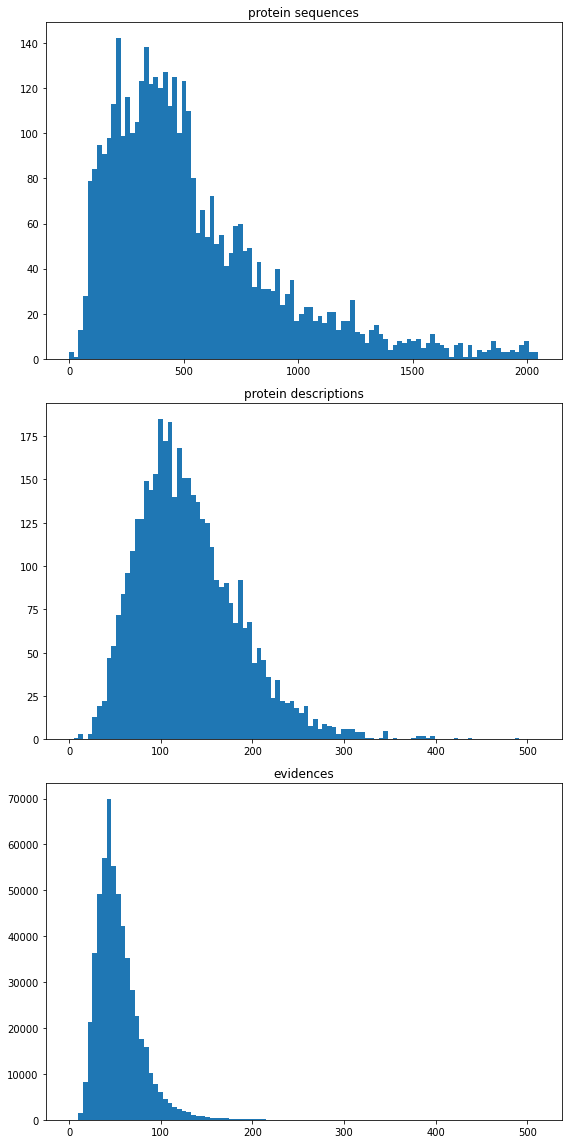

In [34]:
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(8,16))

ranges = [(0,2048), (0,512), (0,512)]

for idx, (length_dist, title, rang) in enumerate(zip(
    [protein_seq_lens, protein_desc_lens, evidences_lens], 
    ["protein sequences", "protein descriptions", "evidences"],
    ranges
)):
    axs[idx].hist(length_dist, bins=100, range=rang)
    axs[idx].title.set_text(title)
    
plt.savefig(os.path.join(VISUALIZATIONS_DIR, "token_lengths_prot_stonkgs.png"), dpi=300)
plt.show()